In [320]:
import pandas as pd
import sys
from tqdm import tqdm
sys.path.append("../")
from tcad.deep.fit import train_vae
from tcad.tools.nntools import SmilesDataSet, SmilesEncoder
from tcad.deep.models import VaeCnn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from rdkit import RDLogger
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.decomposition import PCA

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL) 

In [266]:
# Helper functions
def to_strong_ones(matrix, threshold):
    zero_matrix = np.zeros_like(matrix)

    for idx, row in enumerate(matrix):
        max_val, max_idx = np.max(row), np.argmax(row)
        
        if max_val >= threshold:
            zero_matrix[idx, max_idx] = 1
    
    return zero_matrix


def generate_molecule(model, encode_dim, device):
    with torch.no_grad():
        return model.decoder(torch.randn(512).unsqueeze(0).to(DEVICE)).to(DEVICE).squeeze(0).cpu().numpy().squeeze(0)


def check_smile(smile):
    mol = Chem.MolFromSmiles(smile)
    
    if mol == None:
        return "Not Valid"
    
    return "Valid"

## Loading and onehot encoding SMILEs

In [2]:
data = pd.read_csv("../data/androgen_data.csv")
smiles = data["canonical_smiles"].to_list()

smiles_dataset = SmilesDataSet(smiles)
senc = SmilesEncoder(smiles)
dataloader = DataLoader(smiles_dataset, batch_size=128)

## Have a look at some encoded SMILEs

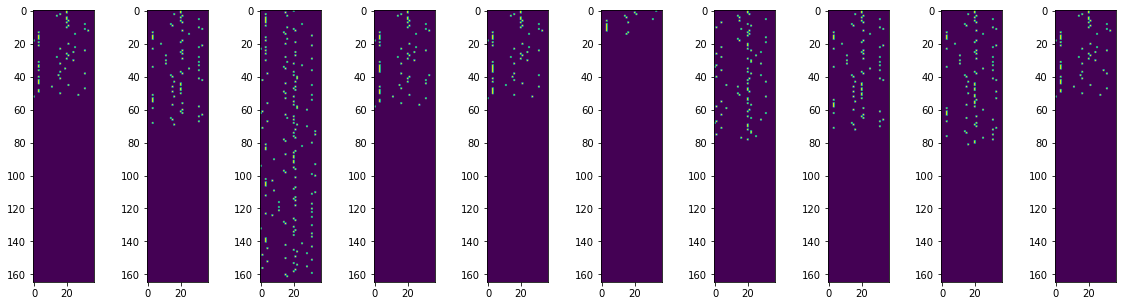

In [86]:
_, ax = plt.subplots(1, 10, figsize = (20, 5))

for i in range(10):
    ax[i].imshow(smiles_dataset[i].squeeze())

## Set up and build model

In [4]:
ENCODE_DIM = 512
model = VaeCnn(desired_dim=ENCODE_DIM).to(DEVICE)

In [271]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train model

In [272]:
losses = train_vae(dataloader, model, optimizer, epochs=100)

Epoch:0 criterion_loss:9.54627 KL_loss:13.75707 total_loss: 23.30335
Epoch:10 criterion_loss:10.18453 KL_loss:13.49963 total_loss: 23.68416
Epoch:20 criterion_loss:9.7377 KL_loss:13.78316 total_loss: 23.52087
Epoch:30 criterion_loss:7.95727 KL_loss:13.7467 total_loss: 21.70397
Epoch:40 criterion_loss:8.25808 KL_loss:13.49335 total_loss: 21.75143
Epoch:50 criterion_loss:8.40663 KL_loss:13.5706 total_loss: 21.97723
Epoch:60 criterion_loss:8.77802 KL_loss:13.67816 total_loss: 22.45618
Epoch:70 criterion_loss:9.48434 KL_loss:13.58339 total_loss: 23.06774
Epoch:80 criterion_loss:11.92655 KL_loss:13.70205 total_loss: 25.6286
Epoch:90 criterion_loss:10.60199 KL_loss:13.71041 total_loss: 24.3124


## Have a look at decoded SMILEs

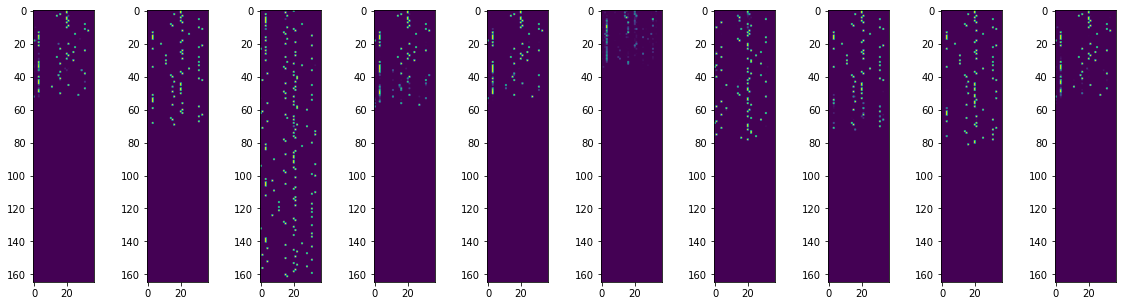

In [273]:
in_data = next(iter(dataloader)).to("cuda")
encoded, _, _, decoded = model(in_data)
out = decoded.detach().cpu().numpy().squeeze()

_, ax = plt.subplots(1, 10, figsize = (20, 5))

for i in range(10):
    ax[i].imshow(out[i])

## Compare original and decoded SMILEs

In [274]:
smile_idx = 6
print(f"Decoded : {senc._decode_smile(to_strong_ones(out[smile_idx], 0.5))}")
print(f"Original: {smiles[smile_idx]}")

Decoded : CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C
Original: CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C


## Have look at some generated data

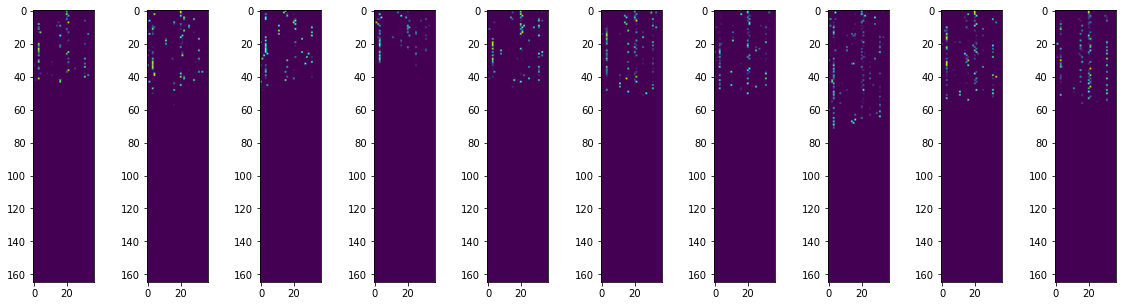

In [275]:
ENCODE_DIM = 512

_, ax = plt.subplots(1, 10, figsize = (20, 5))

for i in range(10):
    ax[i].imshow(generate_molecule(model=model, encode_dim=ENCODE_DIM, device=DEVICE))


## Generate valid molecules by rasndom sampling from n-dimentional normal distribution

In [316]:
generated_smiles = []
n_iters = 100000
min_smile_len = 10
threshold = 0.3

for i in tqdm(range(n_iters)):
    molecule = generate_molecule(model=model, encode_dim=ENCODE_DIM, device=DEVICE)
    smile = senc._decode_smile(to_strong_ones(molecule, threshold))
    
    if check_smile(smile) == 'Valid' and len(smile)>min_smile_len and smile not in smiles:
        generated_smiles.append(smile)

100%|██████████| 100000/100000 [03:56<00:00, 422.14it/s]


## Look at new generated molecules

From 100,000 random vectors sampled 480 valid molecules


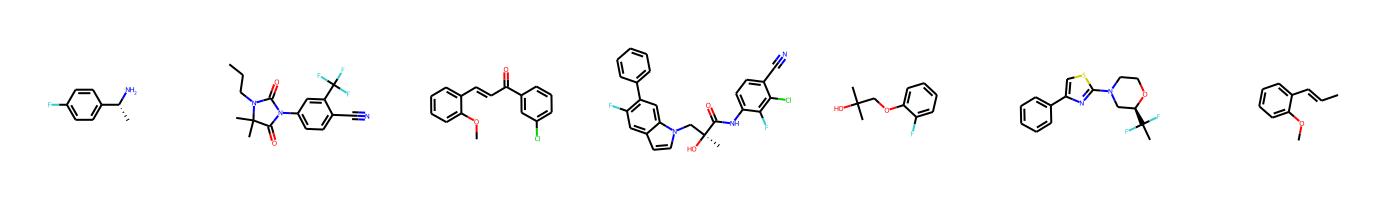

In [324]:
print(f"From {n_iters:,} random vectors sampled {len(generated_smiles)} valid molecules")
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in generated_smiles][0:7], molsPerRow=7)

## Look at 2D distrtibytion of original and generated molecules

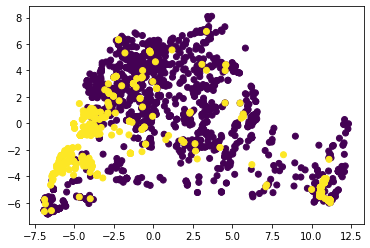

In [322]:
allsmiles = smiles + generated_smiles
labels = [0 for _ in range(len(smiles))] + [1 for _ in range(len(generated_smiles))]

RDKIT_FINGERPRINT_GENERATOR = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
FINGERPRINT_LENGTH = 2048

fingerprints = [RDKIT_FINGERPRINT_GENERATOR.GetFingerprint(Chem.MolFromSmiles(smile)) for smile in allsmiles]
fingerprints_array = np.zeros((len(fingerprints), FINGERPRINT_LENGTH))

for idx, fingerprint in enumerate(fingerprints):
    fingerprints_array[idx] = np.array(fingerprint)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(fingerprints_array)

plt.scatter(x=reduced_data[:,0], y=reduced_data[:,1], c=labels)
plt.show()